In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler

ModuleNotFoundError: No module named 'tensorflow'

In [13]:
# Генерация размеченной выборки данных
def generate_data(num_samples, num_classes):
    X = []
    y = []

    for _ in range(num_samples):
        # Генерация случайного класса
        label = np.random.randint(0, num_classes)
        # Генерация случайной точки согласно заданному распределению
        mean = np.random.randn(2) * 2
        cov = np.eye(2)
        point = np.random.multivariate_normal(mean, cov)
        point = point / (np.linalg.norm(point) + 0.1)  # Применяем формулу для Z_k
        X.append(point)
        y.append(label)

    return np.array(X), np.array(y)

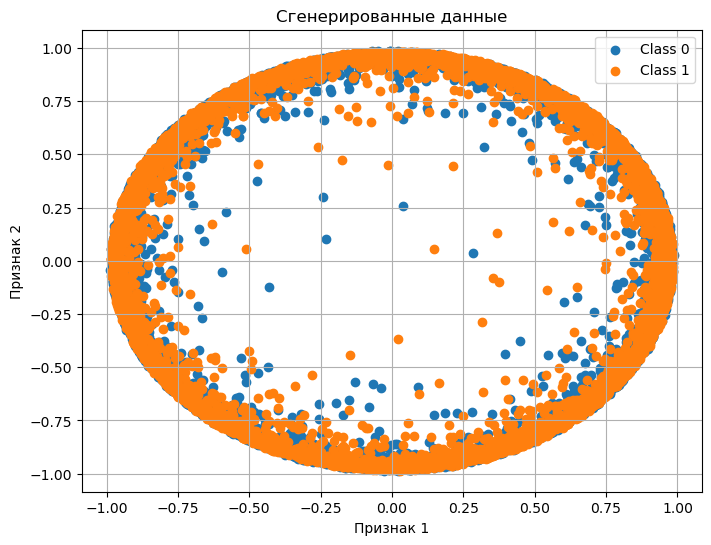

In [15]:
# Параметры генерации данных
num_samples = 10000
num_classes = 2

# Генерация данных
X, y = generate_data(num_samples, num_classes)

# Визуализация данных
plt.figure(figsize=(8, 6))
for class_label in range(num_classes):
    plt.scatter(X[y == class_label][:, 0], X[y == class_label][:, 1], label=f'Class {class_label}')
plt.title('Сгенерированные данные')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели логистической регрессии
model = LogisticRegression(max_iter=1000, multi_class='auto')
model.fit(X_train, y_train)

# Предсказание классов на тестовом наборе
y_pred = model.predict(X_test)

# Оценка точности модели
accuracy = accuracy_score(y_test, y_pred)
print(f'Точность модели: {accuracy}')

Точность модели: 0.5085


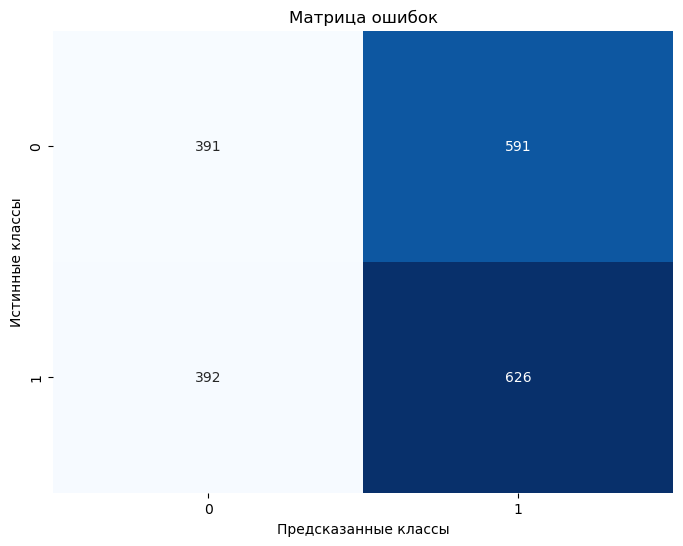

Отчет классификации:
              precision    recall  f1-score   support

           0       0.50      0.40      0.44       982
           1       0.51      0.61      0.56      1018

    accuracy                           0.51      2000
   macro avg       0.51      0.51      0.50      2000
weighted avg       0.51      0.51      0.50      2000


In [17]:
# Вычисление матрицы ошибок
conf_matrix = confusion_matrix(y_test, y_pred)

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Матрица ошибок')
plt.xlabel('Предсказанные классы')
plt.ylabel('Истинные классы')
plt.show()

# Генерация отчета классификации с параметром zero_division=1
class_report = classification_report(y_test, y_pred, zero_division=1)

# Вывод отчета классификации
print('Отчет классификации:')
print(class_report)